## Inequality Measures

#### This notebook reads in the standard dataframe and computes the following inequality measures by looking at the neighborhood-level broadband percentage for each city:

1. Theil Index
2. Atkinson Index
3. Palma Ratio
4. Decile Ratio
5. Gini Index
6. Mean Log Deviation
7. Interquartile Range

#### The notebook also displays the measures all together in a table and in horizontal bar charts. The lower the ranking, the less equitable a given city is.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import inequalipy as ineq
import math
from statistics import mean 

In [2]:
std_df = pd.read_csv('/tmp/data/standard_neighborhood_df.csv')

In [3]:
duplicate_rows = np.where(std_df.duplicated(subset=['City Name', 'Population', 'Households',
       'Neighborhood Size', '% Black', '% Hispanic', '% >25 College Degree',
       'Avg household income', '% Broadband Access', '% > 100MB Access',
       'Devices per capita']))[0]
duplicate_rows

array([  98,  432,  511,  513,  514,  516,  517,  518,  519,  520,  521,
        522,  523,  524,  525,  526,  527,  528,  529,  530,  531,  615,
        616,  736,  805,  812,  827,  839,  849,  855,  857,  859,  902,
       1118, 1126, 1128, 1130, 1134, 1296, 1730])

In [4]:
std_df_no_duplicates = std_df.drop(duplicate_rows)

In [5]:
std_df_no_duplicates = std_df_no_duplicates.dropna()

In [24]:
std_df_no_duplicates

,Unnamed: 0,City Name,Neighborhood Name,Number of Census Tracts,Population,Households,Neighborhood Size,% Black,% Hispanic,% >25 College Degree,Avg household income,% Broadband Access,% > 100MB Access,Devices per capita,geometry
0,0,phoenix,Central City,37,105996.0,38067.0,0.010609,0.105194,0.574167,0.196750,39063.657143,0.671543,0.168297,0.016167,POLYGON ((-112.0160803618199 33.46574650696289...
1,1,phoenix,Rio Vista,5,28130.0,10207.0,0.045333,0.044200,0.112600,0.454200,91086.800000,0.977000,0.293800,0.046000,POLYGON ((-112.2199024052979 33.80495922891052...
2,2,phoenix,Encanto,26,107425.0,42987.0,0.004764,0.073923,0.484692,0.279346,47405.884615,0.739346,0.387923,0.017577,POLYGON ((-112.0650277038108 33.50239879428997...
3,3,phoenix,Deer Valley,59,287554.0,108090.0,0.037723,0.046915,0.192220,0.324475,73912.593220,0.897288,0.149627,0.021068,POLYGON ((-112.0823058738058 33.72598728654323...
4,4,phoenix,Paradise Valley,57,258060.0,105074.0,0.025213,0.035544,0.166561,0.433158,85493.087719,0.900070,0.250509,0.026719,POLYGON ((-111.9975899054118 33.66246433890238...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1781,112,san-francisco,Presidio Heights,5,22845.0,10178.0,0.000862,0.022800,0.083400,0.852800,181934.800000,0.938200,0.383600,0.033000,POLYGON ((-122.4594574409999 37.78949792400005...
1782,113,san-francisco,Lower Haight,8,37561.0,18442.0,0.000261,0.081125,0.158125,0.681500,130528.000000,0.903625,0.164375,0.023875,POLYGON ((-122.4376106239999 37.77406164500007...
1783,114,san-francisco,Seacliff,5,16428.0,6408.0,0.000871,0.062800,0.075800,0.707800,144250.800000,0.913600,0.844400,0.058200,POLYGON ((-122.4934552679999 37.78351817100008...
1784,115,san-francisco,Sunnyside,7,44488.0,13900.0,0.000611,0.050571,0.173857,0.486714,120220.142857,0.929429,0.651571,0.025571,POLYGON ((-122.4488781039999 37.73380982500004...


## Theil Index

In [54]:
def theil_index(df):    
    cities = list(df['City Name'].unique())
    
    result = pd.DataFrame("", index = cities, columns =['Theil Index'])

    for city in cities:
        df_city = df[df['City Name'] == city]
        df_city_broadband = df_city['% Broadband Access']
        df_city_avg_broadband = df_city['% Broadband Access'].mean()
        broadband_quotient = df_city_broadband/df_city_avg_broadband
        log_quotient = np.log(broadband_quotient)
        quotient = broadband_quotient*log_quotient
        N = len(df_city)
        theil = quotient.sum()/N
        
        result.loc[city, 'Theil Index'] = theil
    
    result['Theil Index'] = result['Theil Index'].apply(pd.to_numeric)
    result = result.sort_values('Theil Index', ascending=False)
    
    
    return result

In [69]:
theil_df = theil_index(std_df_no_duplicates)
theil_df.reset_index(inplace=True)
theil_df = theil_df.rename(columns = {'index':'City'})
theil_df['Theil rank'] = theil_df['Theil Index'].rank(ascending=False)
theil_df = theil_df.sort_values(by=['Theil Index'])
theil_df

,City,Theil Index,Theil rank
16,san-jose,0.000627,17.0
15,denver,0.001059,16.0
14,boston,0.001302,15.0
13,portland,0.001501,14.0
12,san-diego,0.001659,13.0
11,san-francisco,0.002640,12.0
10,austin,0.002750,11.0
9,seattle,0.003023,10.0
8,los-angeles,0.003534,9.0
7,louisville,0.005533,8.0


## Atkinson Index

In [56]:
def atkinson_index(df, beta):
    cities = list(df['City Name'].unique())
    
    result = pd.DataFrame("", index = cities, columns =['Atkinson Index'])

    for city in cities:
        df_city = df[df['City Name'] == city]
        df_city_broadband = df_city['% Broadband Access']
        #df_city_population = df_city['Population']
        list_city_broadband = list(df_city_broadband)
        #array_city_population = np.array(df_city_population)
        result.loc[city, 'Atkinson Index'] = ineq.atkinson.index(list_city_broadband, np.absolute(beta))
    
    result['Atkinson Index'] = result['Atkinson Index'].apply(pd.to_numeric)
    result = result.sort_values('Atkinson Index', ascending=False)
    
    return result

In [57]:
# which city contributed most to observed inequality
atkinson_df = atkinson_index(std_df_no_duplicates, 10)
atkinson_df.reset_index(inplace=True)
atkinson_df = atkinson_df.rename(columns = {'index':'City'})
atkinson_df['Atkinson rank'] = atkinson_df['Atkinson Index'].rank(ascending=False)
atkinson_df = atkinson_df.sort_values(by=['Atkinson rank'])
atkinson_df

,City,Atkinson Index,Atkinson rank
0,seattle,0.195750,1.0
1,indianapolis,0.120119,2.0
2,baltimore,0.114208,3.0
3,dallas,0.101215,4.0
4,detroit,0.091052,5.0
5,washington-dc,0.085066,6.0
6,houston,0.078840,7.0
7,phoenix,0.064674,8.0
8,louisville,0.058399,9.0
9,san-francisco,0.048691,10.0


## Palma Ratio

In [58]:
def palma_ratio(df):
    cities = list(df['City Name'].unique())
    
    result = pd.DataFrame("", index = cities, columns =['Palma Ratio'])
    
    for city in cities:
        df_city = df[df['City Name'] == city]
        df_city_broadband = df_city['% Broadband Access']
        array_city_broadband = np.array(df_city_broadband)
        palma_r = np.percentile(array_city_broadband, 90)/np.percentile(array_city_broadband, 40)
        result.loc[city, 'Palma Ratio'] = palma_r
    
    result['Palma Ratio'] = result['Palma Ratio'].apply(pd.to_numeric)
    result = result.sort_values('Palma Ratio', ascending=False)
    
    return result

In [59]:
# A high Palma ratio indicates a greater degree of inequality or unequal broadband distribution in a city
palma_df = palma_ratio(std_df_no_duplicates)
palma_df.reset_index(inplace=True)
palma_df = palma_df.rename(columns = {'index':'City'})
palma_df['Palma rank'] = palma_df['Palma Ratio'].rank(ascending=False)
palma_df = palma_df.sort_values(by=['Palma rank'])
palma_df

,City,Palma Ratio,Palma rank
0,baltimore,1.259507,1.0
1,detroit,1.210189,2.0
2,houston,1.204227,3.0
3,phoenix,1.202374,4.0
4,washington-dc,1.179223,5.0
5,dallas,1.176018,6.0
6,louisville,1.154286,7.0
7,austin,1.120976,8.0
8,indianapolis,1.114981,9.0
9,los-angeles,1.103925,10.0


## Decile Ratio

In [60]:
def decile_ratio(df):
    cities = list(df['City Name'].unique())
    
    result = pd.DataFrame("", index = cities, columns =['Decile Ratio'])
    
    for city in cities:
        df_city = df[df['City Name'] == city]
        df_city_broadband = df_city['% Broadband Access']
        array_city_broadband = np.array(df_city_broadband)
        decile_r = np.percentile(array_city_broadband, 90)/np.percentile(array_city_broadband, 10)
        result.loc[city, 'Decile Ratio'] = decile_r
    
    result['Decile Ratio'] = result['Decile Ratio'].apply(pd.to_numeric)
    result = result.sort_values('Decile Ratio', ascending=False)
    
    return result

In [61]:
# A high Decile ratio indicates a greater degree of inequality or unequal broadband distribution in a city
decile_df = decile_ratio(std_df_no_duplicates)
decile_df.reset_index(inplace=True)
decile_df = decile_df.rename(columns = {'index':'City'})
decile_df['Decile rank'] = decile_df['Decile Ratio'].rank(ascending=False)
decile_df = decile_df.sort_values(by=['Decile rank'])
decile_df

,City,Decile Ratio,Decile rank
0,baltimore,1.546408,1.0
1,dallas,1.461930,2.0
2,detroit,1.402240,3.0
3,washington-dc,1.399631,4.0
4,houston,1.393458,5.0
5,phoenix,1.360162,6.0
6,louisville,1.332063,7.0
7,indianapolis,1.279284,8.0
8,los-angeles,1.255301,9.0
9,austin,1.209779,10.0


## Gini Index

In [62]:
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    gini_index=(fair_area - area) / fair_area
    return gini_index

In [63]:
cities = std_df_no_duplicates['City Name'].unique()

ls = []
for city in cities:
    city_values = std_df_no_duplicates[std_df_no_duplicates['City Name']==city]['% Broadband Access']
    gini_value = gini(city_values)
    ls.append([city, gini_value])
    
gini_data = pd.DataFrame(ls, columns=['City', 'Gini']) 
gini_data.sort_values(by ='Gini', ascending = 0)

gini_data['Gini rank'] = gini_data['Gini'].rank(ascending=False)
gini_data = gini_data.sort_values(by=['Gini rank'])
gini_data

,City,Gini,Gini rank
5,baltimore,0.089235,1.0
1,dallas,0.080311,2.0
2,detroit,0.075162,3.0
13,washington-dc,0.071764,4.0
15,houston,0.071456,5.0
0,phoenix,0.067474,6.0
8,indianapolis,0.060423,7.0
9,louisville,0.059894,8.0
3,los-angeles,0.047017,9.0
6,austin,0.042541,10.0


## Mean Log Deviation

In [64]:
def mean_log_dev(list_of_values):
    log_list = []
    mean_value = list_of_values.mean()
    log_mean = math.log(mean_value)
    for value in list_of_values:
        log_x = math.log(value)
        log_list.append(log_x)
    mean_log = mean(log_list)
    mean_log_dev = log_mean - mean_log
    return mean_log_dev

In [65]:
log_s = []
for city in cities:
    city_values = std_df_no_duplicates[std_df_no_duplicates['City Name']==city]['% Broadband Access']
    mean_log_dev_value = mean_log_dev(city_values)
    log_s.append([city, mean_log_dev_value])
    
mean_log_data = pd.DataFrame(log_s, columns=['City', 'Mean log deviation']) 
mean_log_data['Mean log deviation rank'] = mean_log_data['Mean log deviation'].rank(ascending=False)
mean_log_data = mean_log_data.sort_values(by=['Mean log deviation rank'])
mean_log_data

,City,Mean log deviation,Mean log deviation rank
5,baltimore,0.012341,1.0
1,dallas,0.010920,2.0
2,detroit,0.008899,3.0
13,washington-dc,0.008284,4.0
15,houston,0.007947,5.0
8,indianapolis,0.007255,6.0
0,phoenix,0.007045,7.0
9,louisville,0.005630,8.0
3,los-angeles,0.003610,9.0
4,seattle,0.003474,10.0


## IQR

In [66]:
def iqr_broadband(city): 

    df_city = std_df_no_duplicates[std_df_no_duplicates['City Name'] == city]
    df_city_broadband = df_city['% Broadband Access']
    array_city_broadband = np.array(df_city_broadband)
    Q3 = np.quantile(array_city_broadband, 0.75) 
    Q1 = np.quantile(array_city_broadband, 0.25)
    iqr_results = Q3 - Q1
    
    return iqr_results

In [67]:
results_iqr = []

for city in std_df_no_duplicates['City Name'].unique():
    results_iqr.append(iqr_broadband(city))
    
iqr_broadband_df = pd.DataFrame({'City': std_df_no_duplicates['City Name'].unique(), "IQR Broadband" : results_iqr})
iqr_broadband_df["IQR rank"] = iqr_broadband_df["IQR Broadband"].rank(ascending=False)
iqr_broadband_df = iqr_broadband_df.sort_values(by=["IQR rank"])
iqr_broadband_df

,City,IQR Broadband,IQR rank
1,dallas,0.214285,1.0
5,baltimore,0.194025,2.0
13,washington-dc,0.184029,3.0
0,phoenix,0.157159,4.0
15,houston,0.154765,5.0
9,louisville,0.132357,6.0
2,detroit,0.126714,7.0
6,austin,0.117407,8.0
8,indianapolis,0.108892,9.0
3,los-angeles,0.105280,10.0


## Final Result Summary

In [78]:
inequality_df = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(gini_data,atkinson_df,on='City'),theil_df,on='City'),mean_log_data,on='City'), palma_df,on='City'),decile_df,on='City'),iqr_broadband_df,on='City') 
inequality_df

,City,Gini,Gini rank,Atkinson Index,Atkinson rank,Theil Index,Theil rank,Mean log deviation,Mean log deviation rank,Palma Ratio,Palma rank,Decile Ratio,Decile rank,IQR Broadband,IQR rank
0,baltimore,0.089235,1.0,0.114208,3.0,0.012122,1.0,0.012341,1.0,1.259507,1.0,1.546408,1.0,0.194025,2.0
1,dallas,0.080311,2.0,0.101215,4.0,0.010623,2.0,0.010920,2.0,1.176018,6.0,1.461930,2.0,0.214285,1.0
2,detroit,0.075162,3.0,0.091052,5.0,0.008768,3.0,0.008899,3.0,1.210189,2.0,1.402240,3.0,0.126714,7.0
3,washington-dc,0.071764,4.0,0.085066,6.0,0.008079,4.0,0.008284,4.0,1.179223,5.0,1.399631,4.0,0.184029,3.0
4,houston,0.071456,5.0,0.078840,7.0,0.007816,5.0,0.007947,5.0,1.204227,3.0,1.393458,5.0,0.154765,5.0
5,phoenix,0.067474,6.0,0.064674,8.0,0.006988,6.0,0.007045,7.0,1.202374,4.0,1.360162,6.0,0.157159,4.0
6,indianapolis,0.060423,7.0,0.120119,2.0,0.006793,7.0,0.007255,6.0,1.114981,9.0,1.279284,8.0,0.108892,9.0
7,louisville,0.059894,8.0,0.058399,9.0,0.005533,8.0,0.005630,8.0,1.154286,7.0,1.332063,7.0,0.132357,6.0
8,los-angeles,0.047017,9.0,0.040601,11.0,0.003534,9.0,0.003610,9.0,1.103925,10.0,1.255301,9.0,0.105280,10.0
9,austin,0.042541,10.0,0.027758,12.0,0.002750,11.0,0.002768,12.0,1.120976,8.0,1.209779,10.0,0.117407,8.0


In [86]:
graph_inequality_df =  inequality_df.astype({'Theil rank' : "int", 'Atkinson rank' : "int" ,"Palma rank" : "int", "Decile rank" : "int","Gini rank" : "int", "Mean log deviation rank" : "int", "IQR rank" : "int" })
graph_inequality_df = graph_inequality_df.drop(columns=["Gini rank", "Atkinson rank", "Theil rank", "Palma rank", "Decile rank", "Mean log deviation rank", "IQR rank" ])
graph_inequality_df

In [93]:
measures = list(graph_inequality_df.columns)
measures = measures[1:]
measures

['Gini',
 'Atkinson Index',
 'Theil Index',
 'Mean log deviation',
 'Palma Ratio',
 'Decile Ratio',
 'IQR Broadband']

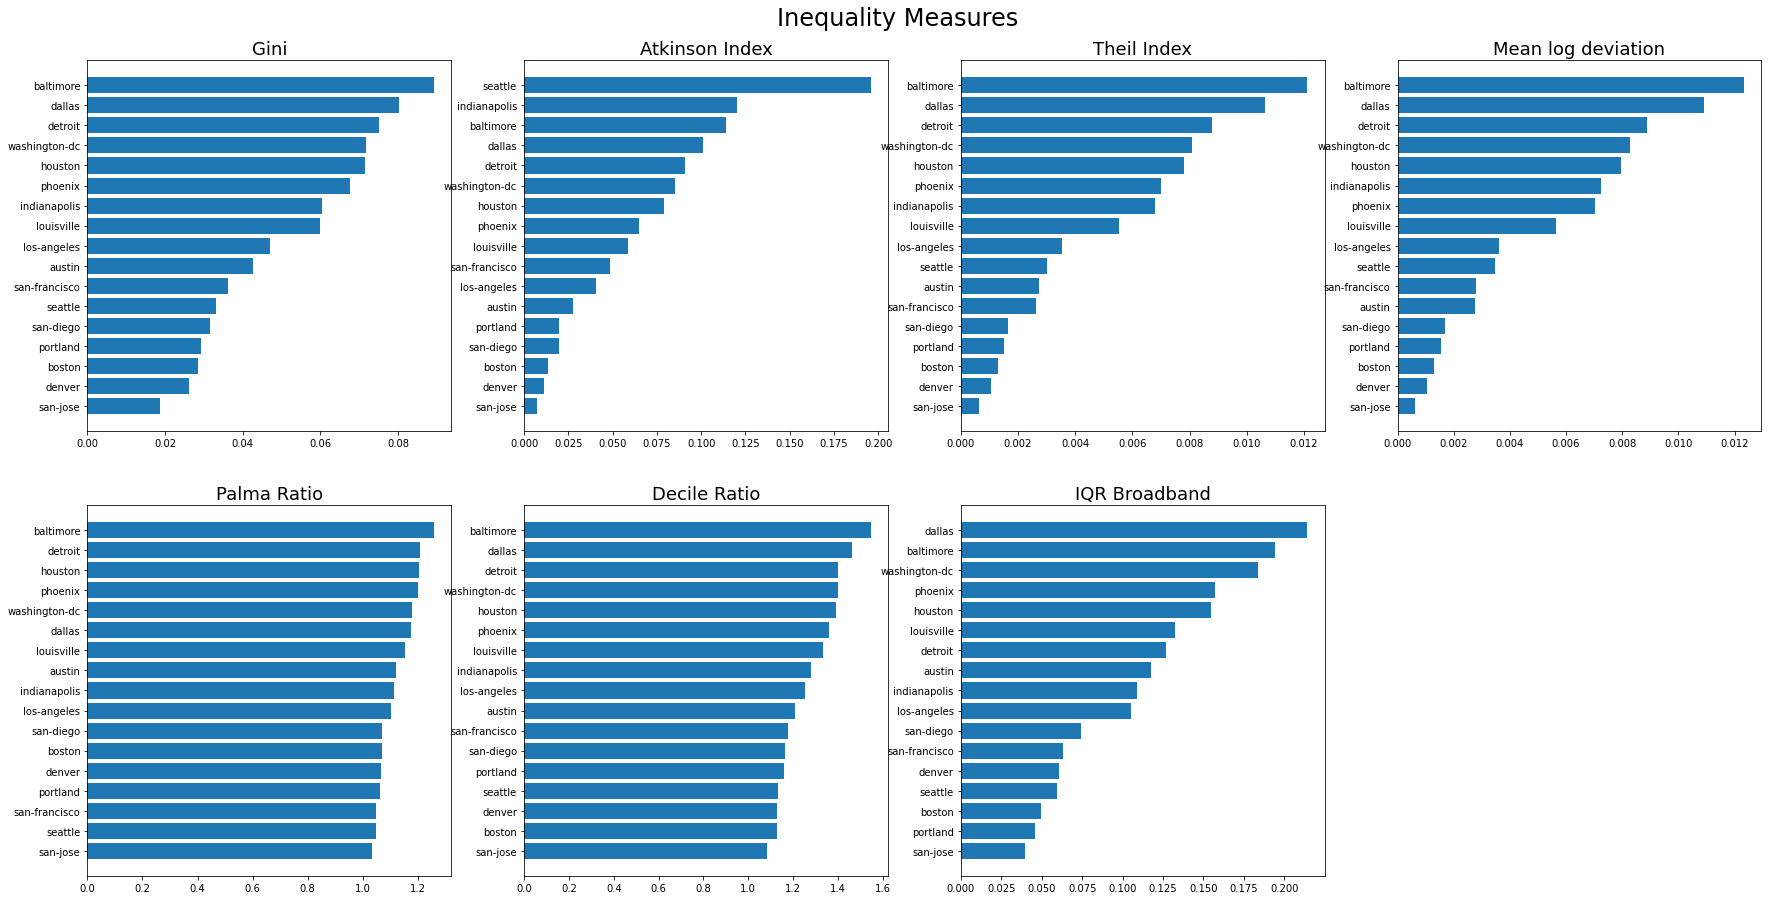

In [136]:
plt.figure(figsize=(30, 15))
plt.suptitle("Inequality Measures", fontsize=24, y=0.93)

for n, measure in enumerate(measures):
    # add a new subplot iteratively
    ax = plt.subplot(2, 4, n + 1)

    graph_inequality_df_sorted = graph_inequality_df.sort_values(measure)
    ax.barh(graph_inequality_df_sorted['City'], graph_inequality_df_sorted[measure])
    
    ax.set_title(measure, fontsize=18)